In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "PLACES"
    city = "manizales"
    
    property_type = "casas"
    post_type = "venta"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
0,5.045668,-75.528992,university,Universidad Antonio Nariño Manizales,5151631,5.06122,-75.472801,6.459578
1,5.045668,-75.528992,university,UAN Universidad Antonio Nariño,5151631,5.06122,-75.472801,6.459578
2,5.001526,-75.598802,university,Mànizales,5151631,5.06122,-75.472801,15.454687
3,4.985796,-75.606928,university,CUN - Corporación Unificada Nacional de Educac...,5151631,5.06122,-75.472801,17.060712
4,4.983539,-75.605624,university,JUZGADO PRIMERO PROMISCUO MUNICIPAL DE CHINCHINÁ,5151631,5.06122,-75.472801,17.060806


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,amenity,name,fid,latitide,longitude,distance
119123,5.042569,-75.514771,secondary_school,sam pedro claver,4340634,5.042569,-75.514771,0.0
119124,5.042569,-75.514771,school,La Florida,4340634,5.042569,-75.514771,0.0
119125,5.042569,-75.514771,school,Cancha Sintética Polideprtivo Villadiana,4340634,5.042569,-75.514771,0.0
119180,5.042569,-75.514771,park,"Cascada Molinos. Villamaria, Caldas",4340634,5.042569,-75.514771,0.0
174106,5.053965,-75.485634,shopping_mall,SEGURIDAD SUPERIOR,4822267,5.053965,-75.485634,0.0
...,...,...,...,...,...,...,...,...
5043895,5.070275,-75.513817,restaurant,"CLUB: NUTRICION ,SALUD, BIENESTAR, TERMOMASAJES",4464609,5.070275,-75.513817,0.0
5043896,5.070275,-75.513817,restaurant,Algussto Manizales,4464609,5.070275,-75.513817,0.0
5043897,5.070275,-75.513817,restaurant,villa pilar hamburguesas,4464609,5.070275,-75.513817,0.0
5043898,5.070275,-75.513817,restaurant,Restaurantes chinos,4464609,5.070275,-75.513817,0.0


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
418,5.054574,-75.495624,university,Colegio Comercial,5151631,5.06122,-75.472801,2.633707
419,5.054832,-75.495770,university,Edificio Bicentenario,5151631,5.06122,-75.472801,2.641379
420,5.054685,-75.495517,university,Sede Micaela U. De Caldas,5151631,5.06122,-75.472801,2.618897
421,5.059320,-75.497738,school,Colegio San Luis Gonzaga,5151631,5.06122,-75.472801,2.770121
427,5.055587,-75.494052,university,Edificio El Parque De La Universidad De Caldas,5151631,5.06122,-75.472801,2.435650


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,2.359569e+06,2.359569e+06,2.359569e+06,2.359569e+06,2.359569e+06
mean,5.060626e+00,-7.550091e+01,5.060240e+00,-7.550023e+01,1.727466e+00
std,1.050330e-02,1.579460e-02,1.122669e-02,1.614626e-02,7.785379e-01
min,5.006339e+00,-7.557273e+01,5.019469e+00,-7.555476e+01,0.000000e+00
25%,5.053953e+00,-7.551418e+01,5.052560e+00,-7.551311e+01,1.108509e+00
50%,5.062942e+00,-7.549987e+01,5.062680e+00,-7.549945e+01,1.765482e+00
75%,5.067669e+00,-7.548878e+01,5.067742e+00,-7.548869e+01,2.400998e+00
max,5.140129e+00,-7.542501e+01,5.117804e+00,-7.544368e+01,2.999998e+00


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity             
1274344 amusement_park     1
        bank             113
        church            75
        hospital          58
        library           10

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,1274344,amusement_park,1
1,1274344,bank,113
2,1274344,church,75
3,1274344,hospital,58
4,1274344,library,10


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [17]:
posts_full["airport"].describe()

count    1992.000000
mean        0.196787
std         0.397670
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: airport, dtype: float64

In [18]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [19]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(1992, 5)

In [20]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

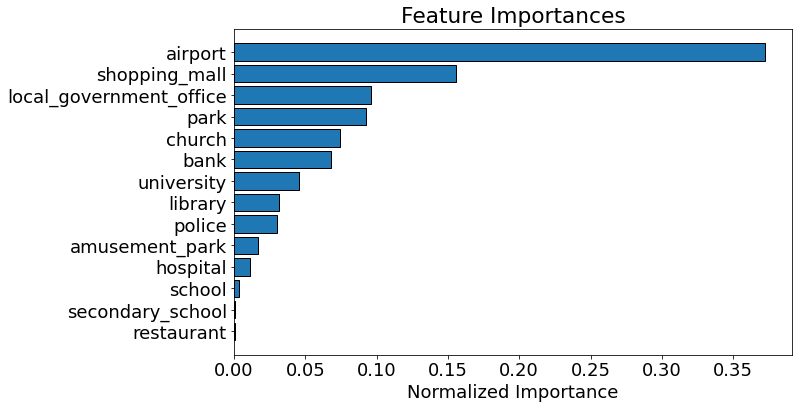

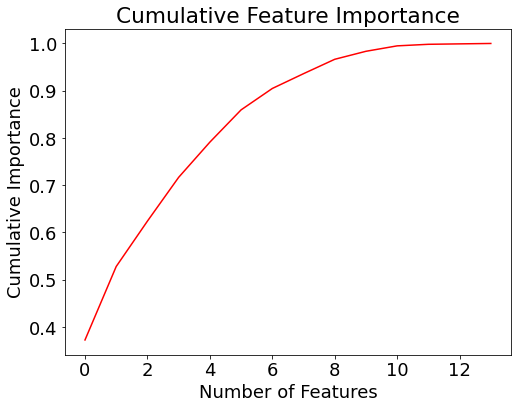

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,13,69.115324,airport,0.372549,0.372549
1,5,28.841357,shopping_mall,0.155462,0.528011
2,8,17.817895,local_government_office,0.096043,0.624054
3,4,17.184497,park,0.092629,0.716683
4,3,13.824142,church,0.074516,0.791198
5,2,12.664378,bank,0.068264,0.859463
6,7,8.400284,university,0.045280,0.904742
7,11,5.810756,library,0.031321,0.936064
8,9,5.647086,police,0.030439,0.966503
9,12,3.141739,amusement_park,0.016935,0.983438


In [21]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [23]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.11787782717291517

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [25]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

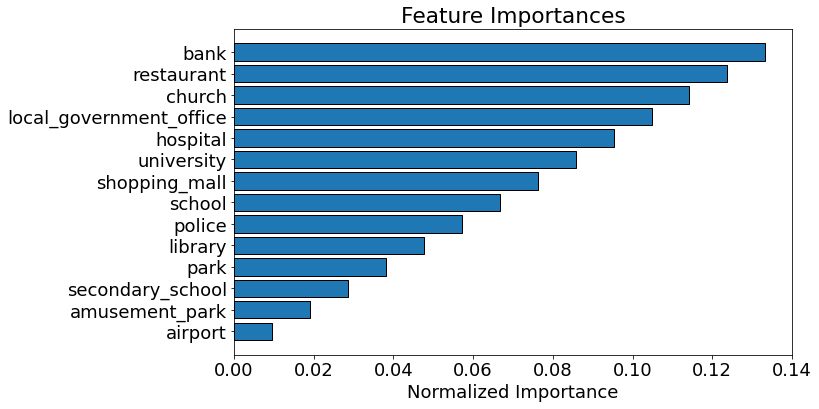

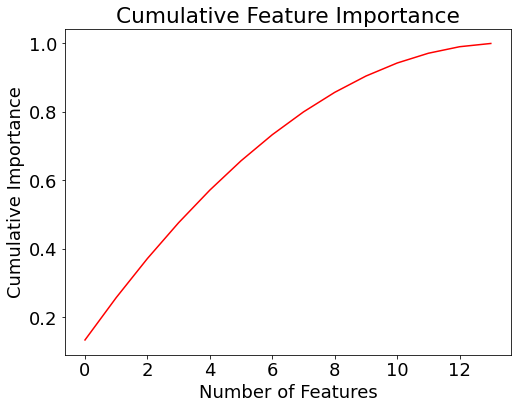

10 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,2,14,bank,0.133333,0.133333
1,0,13,restaurant,0.123810,0.257143
2,3,12,church,0.114286,0.371429
3,8,11,local_government_office,0.104762,0.476190
4,6,10,hospital,0.095238,0.571429
5,7,9,university,0.085714,0.657143
6,5,8,shopping_mall,0.076190,0.733333
7,1,7,school,0.066667,0.800000
8,9,6,police,0.057143,0.857143
9,11,5,library,0.047619,0.904762


In [26]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

In [28]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [29]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

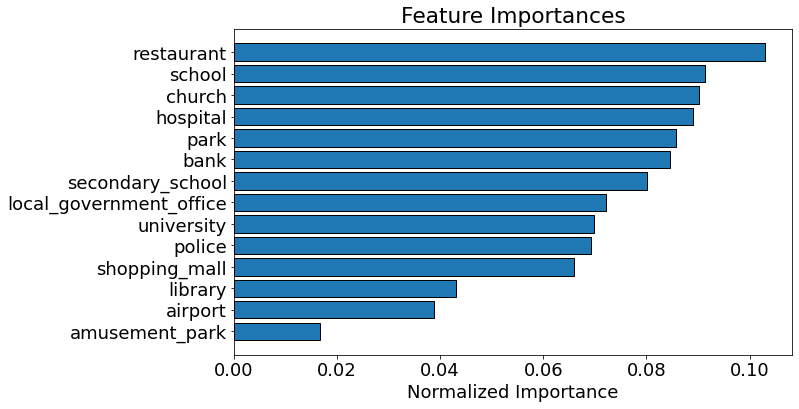

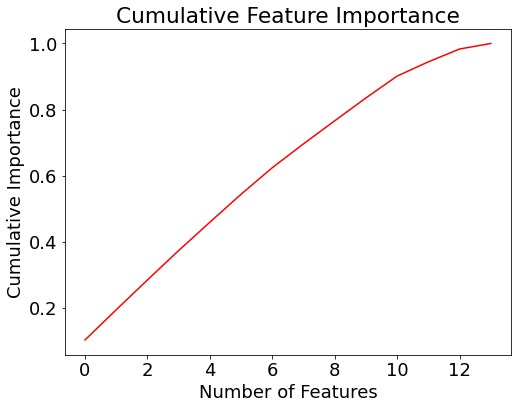

11 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,0.103079,restaurant,0.103079,0.103079
1,1,0.091338,school,0.091338,0.194417
2,3,0.090224,church,0.090224,0.284641
3,6,0.088948,hospital,0.088948,0.373589
4,4,0.085740,park,0.085740,0.459329
5,2,0.084621,bank,0.084621,0.543950
6,10,0.080206,secondary_school,0.080206,0.624156
7,8,0.072208,local_government_office,0.072208,0.696365
8,7,0.069754,university,0.069754,0.766119
9,9,0.069205,police,0.069205,0.835324


In [30]:
plot_feature_importances(feature_importances)